In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import psutil
import GPUtil

In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import timebatch_size = 32
epochs = 5
learning_rate = 0.001
import psutil
import GPUtil

In [2]:
data_dir = r'D:\data'
checkpoint_dir = r'D:\Mini project\weight_save'
os.makedirs(checkpoint_dir, exist_ok=True)

In [3]:
batch_size = 32
epochs = 5
learning_rate = 0.001
input_shape = (64, 64, 3)

In [4]:
def load_images_from_folder(folder_path, image_files):
    images = []
    for filename in image_files:
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path).resize(input_shape[:2])  # Resize image
        img_array = np.array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

In [5]:
def load_data():
    
    with open(os.path.join(data_dir, 'list', 'train.txt'), 'r') as f:
        train_files = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, 'list', 'test.txt'), 'r') as f:
        test_files = [line.strip() for line in f.readlines()]
    with open(os.path.join(data_dir, 'list', 'val.txt'), 'r') as f:
        val_files = [line.strip() for line in f.readlines()]

  
    pre_images = load_images_from_folder(os.path.join(data_dir, 'A'), train_files + test_files + val_files)
    post_images = load_images_from_folder(os.path.join(data_dir, 'B'), train_files + test_files + val_files)

    
    change_maps = load_images_from_folder(os.path.join(data_dir, 'label'), train_files + test_files + val_files)
    change_maps = np.expand_dims(change_maps, axis=-1)

    return pre_images, post_images, change_maps

In [6]:
pre_images, post_images, change_maps = load_data()

In [7]:
def build_siamese_model():
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

   
    def conv_layers(x):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        return x

    
    conv_base_a = conv_layers(input_a)
    conv_base_b = conv_layers(input_b)

  
    merged = Concatenate()([conv_base_a, conv_base_b])


    upsampled = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(merged)
    upsampled = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(upsampled)
    
    output = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(upsampled)  # Final output layer with target resolution

    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

In [8]:
model = build_siamese_model()
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
time_stamps = []
cpu_usages = []
memory_usages = []
gpu_usages = []
epoch_durations = []
images_processed = []
accuracy_over_images = []
loss_over_images = []
time_over_images = []

In [10]:
import time
import os
import psutil
import GPUtil
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint


class IoUScore(tf.keras.metrics.Metric):
    def __init__(self, name='iou_score', threshold=0.5, **kwargs):
        super(IoUScore, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
        
        iou = tf.where(union > 0, intersection / union, 1.0)
        mean_iou = tf.reduce_mean(iou)
        
        self.total_iou.assign_add(mean_iou)
        self.count.assign_add(1.0)

    def result(self):
        return self.total_iou / self.count

    def reset_state(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

start_time = time.time()

process = psutil.Process(os.getpid())
cpu_usage_before = process.cpu_percent(interval=1)
memory_usage_before = process.memory_info().rss / (1024 ** 2)  # Memory in MB

gpus = GPUtil.getGPUs()
gpu_usage_before = gpus[0].memoryUsed if gpus else 0  # GPU memory in MB

def monitor_metrics():
    """Track CPU, memory, and GPU usage."""
    time_stamps.append(time.time())
    cpu_usages.append(process.cpu_percent(interval=None))
    memory_usages.append(process.memory_info().rss / (1024 ** 2))  # Convert bytes to MB
    if gpus:
        gpu_usages.append(gpus[0].memoryUsed)

class MetricsTracker(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        
    def on_batch_end(self, batch, logs=None):
        # Track metrics for each batch
        images_processed.append((batch + 1) * batch_size)  # Total images processed
        accuracy_over_images.append(logs.get('accuracy', 0))
        loss_over_images.append(logs.get('loss', 0))
        time_over_images.append(time.time() - self.epoch_start_time)
        
    def on_epoch_end(self, epoch, logs=None):
        monitor_metrics()
        epoch_durations.append(time.time() - self.epoch_start_time)
        print(f"\nEpoch {epoch + 1} - IoU Score: {logs.get('iou_score', 0):.4f}")


model.compile(
    optimizer=model.optimizer,
    loss=model.loss,
    metrics=['accuracy',IoUScore(name='iou_score') ]
)


checkpoint_path = os.path.join(checkpoint_dir, 'model.{epoch:02d}-{val_loss:.2f}-{val_iou_score:.4f}.keras')
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True
)



history = model.fit(
    [pre_images, post_images], change_maps,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[checkpoint_callback, MetricsTracker()]
)

end_time = time.time()
duration = end_time - start_time


cpu_usage_after = process.cpu_percent(interval=1)
memory_usage_after = process.memory_info().rss / (1024 ** 2)  # Memory in MB
gpu_usage_after = gpus[0].memoryUsed if gpus else 0  # GPU memory in MB


print(f"\nTraining Results:")
print(f"Total training time: {duration:.2f} seconds")
print(f"CPU usage before training: {cpu_usage_before}%")
print(f"CPU usage after training: {cpu_usage_after}%")
print(f"Memory usage before training: {memory_usage_before:.2f} MB")
print(f"Memory usage after training: {memory_usage_after:.2f} MB")
if gpus:
    print(f"GPU memory usage before training: {gpu_usage_before:.2f} MB")
    print(f"GPU memory usage after training: {gpu_usage_after:.2f} MB")


final_iou = history.history['val_iou_score'][-1]
print(f"Final Validation IoU Score: {final_iou:.4f}")


model.save('siamese_change_detection_model.keras')

Epoch 1/5


191/191 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9502 - iou_score: 0.7174
Epoch 1 - IoU Score: 0.7174
191/191 [==============================] - 60s 282ms/step - loss: 0.2067 - accuracy: 0.9502 - iou_score: 0.7174 - val_loss: 0.1509 - val_accuracy: 0.9508 - val_iou_score: 0.7445
Epoch 2/5
191/191 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9527 - iou_score: 0.7491
Epoch 2 - IoU Score: 0.7491
191/191 [==============================] - 49s 258ms/step - loss: 0.1406 - accuracy: 0.9527 - iou_score: 0.7491 - val_loss: 0.1391 - val_accuracy: 0.9508 - val_iou_score: 0.7445
Epoch 3/5
191/191 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9535 - iou_score: 0.7467
Epoch 3 - IoU Score: 0.7467
191/191 [==============================] - 50s 260ms/step - loss: 0.1238 - accuracy: 0.9535 - iou_score: 0.7467 - val_loss: 0.1402 - val_accuracy: 0.9511 - val_iou_score: 0.7454
Epoch 4/5
191/191 [================

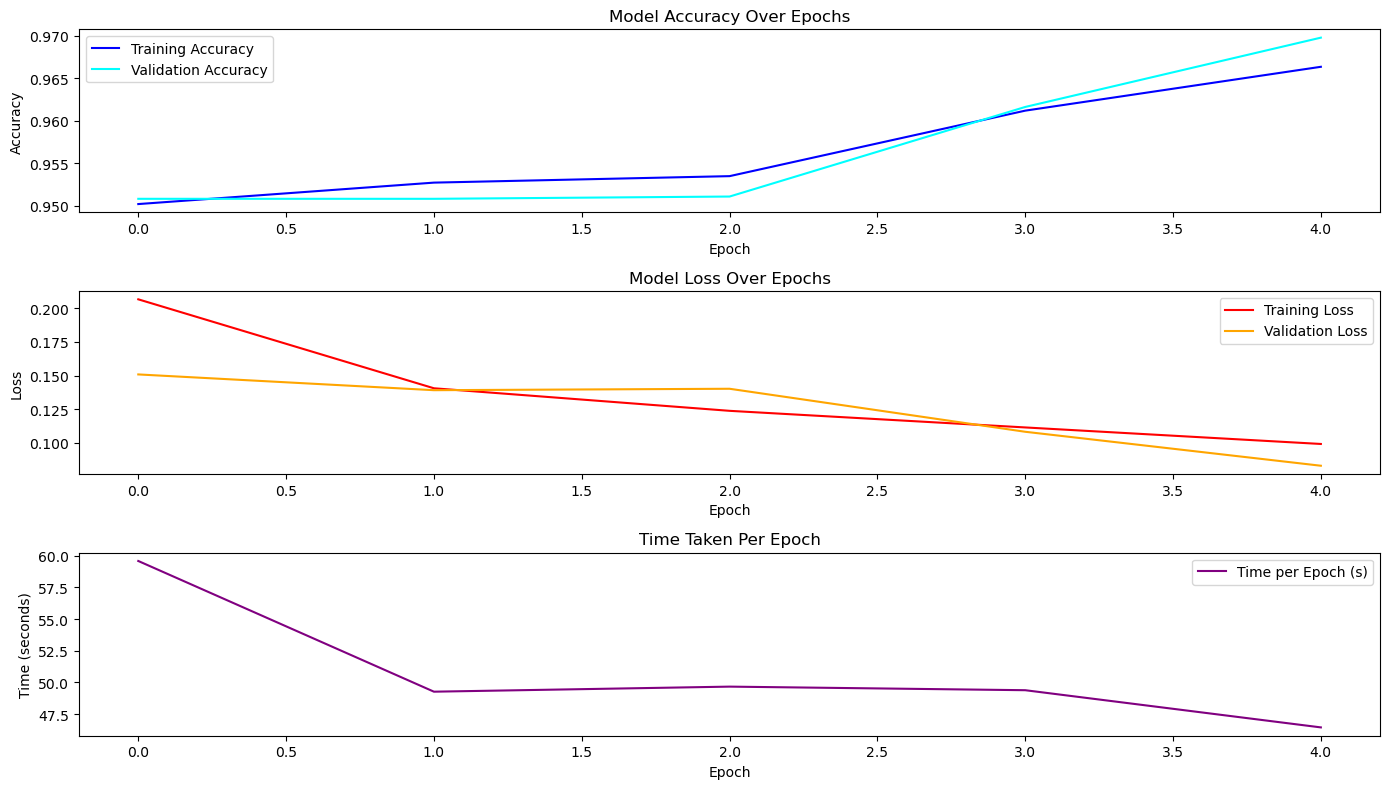

Total training time: 258.06 seconds


In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))


plt.subplot(3, 1, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(history.epoch, history.history['loss'], label='Training Loss', color='red')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(range(len(epoch_durations)), epoch_durations, label='Time per Epoch (s)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time Taken Per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


print(f"Total training time: {duration:.2f} seconds")

238/238 [==============================] - 16s 65ms/step


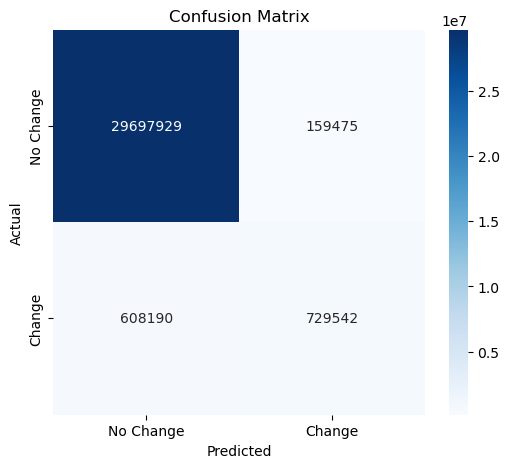


Classification Report:
              precision    recall  f1-score   support

   No Change       0.98      0.99      0.99  29857404
      Change       0.82      0.55      0.66   1337732

    accuracy                           0.98  31195136
   macro avg       0.90      0.77      0.82  31195136
weighted avg       0.97      0.98      0.97  31195136



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the model
y_pred = model.predict([pre_images, post_images])

# Binarize predictions
y_pred_flat = (y_pred > 0.5).astype(np.uint8).flatten()

# Ensure labels are in binary 0 or 1 format
y_true = (change_maps > 0.5).astype(np.uint8)  # If your masks are 0/255 or float
y_true_flat = y_true.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
labels = ['No Change', 'Change']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=labels))

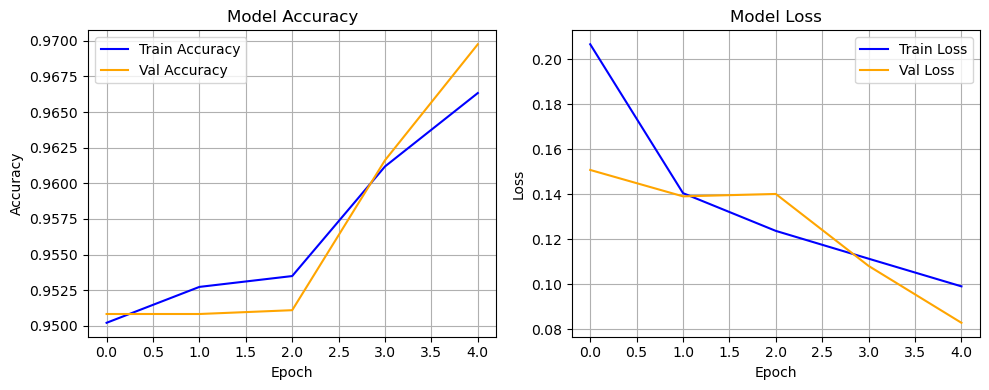

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history.get('val_accuracy', []), label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history.get('val_loss', []), label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
# Save full model
model.save('siamese_change_detection_model.keras')

# Save only weights
weights_path = os.path.join(checkpoint_dir, 'final_model_weights.weights.h5')
model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

Model weights saved to: D:\Mini project\weight_save\final_model_weights.weights.h5
